In [49]:
from typing import List, Optional

In [50]:
import os
from functools import partial
import numpy as np
import pandas as pd
import seaborn as sns
import torch
import torch.nn as nn

import matplotlib
import matplotlib.pyplot as plt
plt.style.use("ggplot")
import pyro
from pyro.distributions import Normal, Uniform, Delta
from pyro.infer import SVI, Trace_ELBO
from pyro.optim import Adam
from pyro.distributions.util import logsumexp
from pyro.infer import EmpiricalMarginal, SVI, Trace_ELBO, TracePredictive
from pyro.infer.mcmc import MCMC, NUTS
import pyro.optim as optim
import pyro.poutine as poutine

# for CI testing
smoke_test = ('CI' in os.environ)
# assert pyro.__version__.startswith('0.3.1')
pyro.enable_validation(True)
pyro.set_rng_seed(1)
pyro.enable_validation(True)

In [ ]:
DATA_URL = "https://d2fefpcigoriu7.cloudfront.net/datasets/rugged_data.csv"
data = pd.read_csv(DATA_URL, encoding="ISO-8859-1")
df = data[["cont_africa", "rugged", "rgdppc_2000"]]
df = df[np.isfinite(df.rgdppc_2000)]
df["rgdppc_2000"] = np.log(df["rgdppc_2000"])

In [ ]:
df.info()

In [ ]:
sns.distplot(df["rugged"])

In [8]:
class OLS(nn.Module):
    def __init__(self, num_params):
        super(OLS, self).__init__()
        self.linear = nn.Linear(num_params, 1)
        
    def forward(self, x):
        return self.linear(x)

In [9]:
model = OLS(3)

In [27]:
x_data = torch.rand(1000, 3)

In [28]:
y_data = x_data @ torch.tensor([[2],[-1], [1]], dtype=torch.float32) + torch.tensor(1e-2)

In [29]:
loss_fn = torch.nn.MSELoss(reduction='sum')
optim = torch.optim.Adam(model.parameters(), lr=0.1)
num_iterations = 1000


def main():
    for j in range(num_iterations):
        # run the model forward on the data
        y_pred = model(x_data).squeeze(-1)
        # calculate the mse loss
        loss = loss_fn(y_pred, y_data)
        # initialize gradients to zero
        optim.zero_grad()
        # backpropagate
        loss.backward()
        # take a gradient step
        optim.step()
        if (j + 1) % 50 == 0:
            print("[iteration %04d] loss: %.4f" % (j + 1, loss.item()))
    # Inspect learned parameters
    print("Learned parameters:")
    for name, param in model.named_parameters():
        print(name, param.data.numpy())

main()

[iteration 0050] loss: 520445.4062
[iteration 0100] loss: 513166.5625
[iteration 0150] loss: 513060.3750
[iteration 0200] loss: 513060.2188
[iteration 0250] loss: 513060.2188
[iteration 0300] loss: 513060.2188
[iteration 0350] loss: 513060.2188
[iteration 0400] loss: 513060.2188
[iteration 0450] loss: 513060.2188
[iteration 0500] loss: 513060.2188
[iteration 0550] loss: 513060.2188
[iteration 0600] loss: 513060.2188
[iteration 0650] loss: 513060.2188
[iteration 0700] loss: 513060.2188
[iteration 0750] loss: 513060.2188
[iteration 0800] loss: 513060.2188
[iteration 0850] loss: 513060.2188
[iteration 0900] loss: 513060.2188
[iteration 0950] loss: 513060.2188
[iteration 1000] loss: 513060.2188
Learned parameters:
linear.weight [[-4.3415810e-08 -4.8128971e-08 -4.6952252e-08]]
linear.bias [0.9787512]


In [ ]:
## Bayesian Regression

In [ ]:
def model(x_data, y_data):
    # weight and bias priors
    w_prior = Normal(torch.zeros(1, 2), torch.ones(1, 2)).to_event(1)
    b_prior = Normal(torch.tensor([[8.]]), torch.tensor([[1000.]])).to_event(1)
    f_prior = Normal(0., 1.)
    priors = {'linear.weight': w_prior, 'linear.bias': b_prior, 'factor': f_prior}
    scale = pyro.sample("sigma", Uniform(0., 10.))
    # lift module parameters to random variables sampled from the priors
    lifted_module = pyro.random_module("module", regression_model, priors)
    # sample a nn (which also samples w and b)
    lifted_reg_model = lifted_module()
    with pyro.plate("map", len(x_data)):
        # run the nn forward on data
        prediction_mean = lifted_reg_model(x_data).squeeze(-1)
        # condition on the observed data
        pyro.sample("obs",
                    Normal(prediction_mean, scale),
                    obs=y_data)
        return prediction_mean

In [ ]:
from pyro.contrib.autoguide import AutoDiagonalNormal
guide = AutoDiagonalNormal(model)

In [ ]:
optim = Adam({"lr": 0.03})
svi = SVI(model, guide, optim, loss=Trace_ELBO(), num_samples=1000)

In [ ]:
def train():
    pyro.clear_param_store()
    for j in range(num_iterations):
        # calculate the loss and take a gradient step
        loss = svi.step(x_data, y_data)
        if j % 100 == 0:
            print("[iteration %04d] loss: %.4f" % (j + 1, loss / len(data)))

train()

In [ ]:
for name, value in pyro.get_param_store().items():
    print(name, pyro.param(name))

In [ ]:
get_marginal = lambda traces, sites:EmpiricalMarginal(traces, sites)._get_samples_and_weights()[0].detach().cpu().numpy()

def summary(traces, sites):
    marginal = get_marginal(traces, sites)
    site_stats = {}
    for i in range(marginal.shape[1]):
        site_name = sites[i]
        marginal_site = pd.DataFrame(marginal[:, i]).transpose()
        describe = partial(pd.Series.describe, percentiles=[.05, 0.25, 0.5, 0.75, 0.95])
        site_stats[site_name] = marginal_site.apply(describe, axis=1) \
            [["mean", "std", "5%", "25%", "50%", "75%", "95%"]]
    return site_stats

def wrapped_model(x_data, y_data):
    pyro.sample("prediction", Delta(model(x_data, y_data)))

posterior = svi.run(x_data, y_data)


In [ ]:
# posterior predictive distribution we can get samples from
trace_pred = TracePredictive(wrapped_model,
                             posterior,
                             num_samples=1000)
post_pred = trace_pred.run(x_data, None)
post_summary = summary(post_pred, sites= ['prediction', 'obs'])
mu = post_summary["prediction"]
y = post_summary["obs"]
predictions = pd.DataFrame({
    "cont_africa": x_data[:, 0],
    "rugged": x_data[:, 1],
    "mu_mean": mu["mean"],
    "mu_perc_5": mu["5%"],
    "mu_perc_95": mu["95%"],
    "y_mean": y["mean"],
    "y_perc_5": y["5%"],
    "y_perc_95": y["95%"],
    "true_gdp": y_data,
})

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 6), sharey=True)
african_nations = predictions[predictions["cont_africa"] == 1]
non_african_nations = predictions[predictions["cont_africa"] == 0]
african_nations = african_nations.sort_values(by=["rugged"])
non_african_nations = non_african_nations.sort_values(by=["rugged"])
fig.suptitle("Regression line 90% CI", fontsize=16)
ax[0].plot(non_african_nations["rugged"],
           non_african_nations["mu_mean"])
ax[0].fill_between(non_african_nations["rugged"],
                   non_african_nations["mu_perc_5"],
                   non_african_nations["mu_perc_95"],
                   alpha=0.5)
ax[0].plot(non_african_nations["rugged"],
           non_african_nations["true_gdp"],
           "o")
ax[0].set(xlabel="Terrain Ruggedness Index",
          ylabel="log GDP (2000)",
          title="Non African Nations")
idx = np.argsort(african_nations["rugged"])
ax[1].plot(african_nations["rugged"],
           african_nations["mu_mean"])
ax[1].fill_between(african_nations["rugged"],
                   african_nations["mu_perc_5"],
                   african_nations["mu_perc_95"],
                   alpha=0.5)
ax[1].plot(african_nations["rugged"],
           african_nations["true_gdp"],
           "o")
ax[1].set(xlabel="Terrain Ruggedness Index",
          ylabel="log GDP (2000)",
          title="African Nations")

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 6), sharey=True)
fig.suptitle("Posterior predictive distribution with 90% CI", fontsize=16)
ax[0].plot(non_african_nations["rugged"],
           non_african_nations["y_mean"])
ax[0].fill_between(non_african_nations["rugged"],
                   non_african_nations["y_perc_5"],
                   non_african_nations["y_perc_95"],
                   alpha=0.5)
ax[0].plot(non_african_nations["rugged"],
           non_african_nations["true_gdp"],
           "o")
ax[0].set(xlabel="Terrain Ruggedness Index",
          ylabel="log GDP (2000)",
          title="Non African Nations")
idx = np.argsort(african_nations["rugged"])

ax[1].plot(african_nations["rugged"],
           african_nations["y_mean"])
ax[1].fill_between(african_nations["rugged"],
                   african_nations["y_perc_5"],
                   african_nations["y_perc_95"],
                   alpha=0.5)
ax[1].plot(african_nations["rugged"],
           african_nations["true_gdp"],
           "o")
ax[1].set(xlabel="Terrain Ruggedness Index",
          ylabel="log GDP (2000)",
          title="African Nations")

In [ ]:
# we need to prepend `module$$$` to all parameters of nn.Modules since
# that is how they are stored in the ParamStore
weight = get_marginal(posterior, ['module$$$linear.weight']).squeeze(1).squeeze(1)
factor = get_marginal(posterior, ['module$$$factor'])
gamma_within_africa = weight[:, 1] + factor.squeeze(1)
gamma_outside_africa = weight[:, 1]
fig = plt.figure(figsize=(10, 6))
sns.distplot(gamma_within_africa, kde_kws={"label": "African nations"},)
sns.distplot(gamma_outside_africa, kde_kws={"label": "Non-African nations"})
fig.suptitle("Density of Slope : log(GDP) vs. Terrain Ruggedness", fontsize=16)

In [32]:
# taken from CRF implementation https://raw.githubusercontent.com/kmkurn/pytorch-crf/master/torchcrf/__init__.py
class CRF(nn.Module):
    """Conditional random field.

    This module implements a conditional random field [LMP01]_. The forward computation
    of this class computes the log likelihood of the given sequence of tags and
    emission score tensor. This class also has `~CRF.decode` method which finds
    the best tag sequence given an emission score tensor using `Viterbi algorithm`_.

    Args:
        num_tags: Number of tags.
        batch_first: Whether the first dimension corresponds to the size of a minibatch.

    Attributes:
        start_transitions (`~torch.nn.Parameter`): Start transition score tensor of size
            ``(num_tags,)``.
        end_transitions (`~torch.nn.Parameter`): End transition score tensor of size
            ``(num_tags,)``.
        transitions (`~torch.nn.Parameter`): Transition score tensor of size
            ``(num_tags, num_tags)``.


    .. [LMP01] Lafferty, J., McCallum, A., Pereira, F. (2001).
       "Conditional random fields: Probabilistic models for segmenting and
       labeling sequence data". *Proc. 18th International Conf. on Machine
       Learning*. Morgan Kaufmann. pp. 282–289.

    .. _Viterbi algorithm: https://en.wikipedia.org/wiki/Viterbi_algorithm
    """

    def __init__(self, num_tags: int, batch_first: bool = False) -> None:
        if num_tags <= 0:
            raise ValueError(f'invalid number of tags: {num_tags}')
        super().__init__()
        self.num_tags = num_tags
        self.batch_first = batch_first
        self.start_transitions = nn.Parameter(torch.empty(num_tags))
        self.end_transitions = nn.Parameter(torch.empty(num_tags))
        self.transitions = nn.Parameter(torch.empty(num_tags, num_tags))

        self.reset_parameters()

    def reset_parameters(self) -> None:
        """Initialize the transition parameters.

        The parameters will be initialized randomly from a uniform distribution
        between -0.1 and 0.1.
        """
        nn.init.uniform_(self.start_transitions, -0.1, 0.1)
        nn.init.uniform_(self.end_transitions, -0.1, 0.1)
        nn.init.uniform_(self.transitions, -0.1, 0.1)

    def __repr__(self) -> str:
        return f'{self.__class__.__name__}(num_tags={self.num_tags})'

    def forward(
            self,
            emissions: torch.Tensor,
            tags: torch.LongTensor,
            mask: Optional[torch.ByteTensor] = None,
            reduction: str = 'sum',
    ) -> torch.Tensor:
        """Compute the conditional log likelihood of a sequence of tags given emission scores.

        Args:
            emissions (`~torch.Tensor`): Emission score tensor of size
                ``(seq_length, batch_size, num_tags)`` if ``batch_first`` is ``False``,
                ``(batch_size, seq_length, num_tags)`` otherwise.
            tags (`~torch.LongTensor`): Sequence of tags tensor of size
                ``(seq_length, batch_size)`` if ``batch_first`` is ``False``,
                ``(batch_size, seq_length)`` otherwise.
            mask (`~torch.ByteTensor`): Mask tensor of size ``(seq_length, batch_size)``
                if ``batch_first`` is ``False``, ``(batch_size, seq_length)`` otherwise.
            reduction: Specifies  the reduction to apply to the output:
                ``none|sum|mean|token_mean``. ``none``: no reduction will be applied.
                ``sum``: the output will be summed over batches. ``mean``: the output will be
                averaged over batches. ``token_mean``: the output will be averaged over tokens.

        Returns:
            `~torch.Tensor`: The log likelihood. This will have size ``(batch_size,)`` if
            reduction is ``none``, ``()`` otherwise.
        """
        self._validate(emissions, tags=tags, mask=mask)
        if reduction not in ('none', 'sum', 'mean', 'token_mean'):
            raise ValueError(f'invalid reduction: {reduction}')
        if mask is None:
            mask = torch.ones_like(tags, dtype=torch.uint8)

        if self.batch_first:
            emissions = emissions.transpose(0, 1)
            tags = tags.transpose(0, 1)
            mask = mask.transpose(0, 1)

        # shape: (batch_size,)
        numerator = self._compute_score(emissions, tags, mask)
        # shape: (batch_size,)
        denominator = self._compute_normalizer(emissions, mask)
        # shape: (batch_size,)
        llh = numerator - denominator

        if reduction == 'none':
            return llh
        if reduction == 'sum':
            return llh.sum()
        if reduction == 'mean':
            return llh.mean()
        assert reduction == 'token_mean'
        return llh.sum() / mask.float().sum()

    def decode(self, emissions: torch.Tensor,
               mask: Optional[torch.ByteTensor] = None) -> List[List[int]]:
        """Find the most likely tag sequence using Viterbi algorithm.

        Args:
            emissions (`~torch.Tensor`): Emission score tensor of size
                ``(seq_length, batch_size, num_tags)`` if ``batch_first`` is ``False``,
                ``(batch_size, seq_length, num_tags)`` otherwise.
            mask (`~torch.ByteTensor`): Mask tensor of size ``(seq_length, batch_size)``
                if ``batch_first`` is ``False``, ``(batch_size, seq_length)`` otherwise.

        Returns:
            List of list containing the best tag sequence for each batch.
        """
        self._validate(emissions, mask=mask)
        if mask is None:
            mask = emissions.new_ones(emissions.shape[:2], dtype=torch.uint8)

        if self.batch_first:
            emissions = emissions.transpose(0, 1)
            mask = mask.transpose(0, 1)

        return self._viterbi_decode(emissions, mask)

    def _validate(
            self,
            emissions: torch.Tensor,
            tags: Optional[torch.LongTensor] = None,
            mask: Optional[torch.ByteTensor] = None) -> None:
        if emissions.dim() != 3:
            raise ValueError(f'emissions must have dimension of 3, got {emissions.dim()}')
        if emissions.size(2) != self.num_tags:
            raise ValueError(
                f'expected last dimension of emissions is {self.num_tags}, '
                f'got {emissions.size(2)}')

        if tags is not None:
            if emissions.shape[:2] != tags.shape:
                raise ValueError(
                    'the first two dimensions of emissions and tags must match, '
                    f'got {tuple(emissions.shape[:2])} and {tuple(tags.shape)}')

        if mask is not None:
            if emissions.shape[:2] != mask.shape:
                raise ValueError(
                    'the first two dimensions of emissions and mask must match, '
                    f'got {tuple(emissions.shape[:2])} and {tuple(mask.shape)}')
            no_empty_seq = not self.batch_first and mask[0].all()
            no_empty_seq_bf = self.batch_first and mask[:, 0].all()
            if not no_empty_seq and not no_empty_seq_bf:
                raise ValueError('mask of the first timestep must all be on')

    def _compute_score(
            self, emissions: torch.Tensor, tags: torch.LongTensor,
            mask: torch.ByteTensor) -> torch.Tensor:
        # emissions: (seq_length, batch_size, num_tags)
        # tags: (seq_length, batch_size)
        # mask: (seq_length, batch_size)
        assert emissions.dim() == 3 and tags.dim() == 2
        assert emissions.shape[:2] == tags.shape
        assert emissions.size(2) == self.num_tags
        assert mask.shape == tags.shape
        assert mask[0].all()

        seq_length, batch_size = tags.shape
        mask = mask.float()

        # Start transition score and first emission
        # shape: (batch_size,)
        score = self.start_transitions[tags[0]]
        score += emissions[0, torch.arange(batch_size), tags[0]]

        for i in range(1, seq_length):
            # Transition score to next tag, only added if next timestep is valid (mask == 1)
            # shape: (batch_size,)
            score += self.transitions[tags[i - 1], tags[i]] * mask[i]

            # Emission score for next tag, only added if next timestep is valid (mask == 1)
            # shape: (batch_size,)
            score += emissions[i, torch.arange(batch_size), tags[i]] * mask[i]

        # End transition score
        # shape: (batch_size,)
        seq_ends = mask.long().sum(dim=0) - 1
        # shape: (batch_size,)
        last_tags = tags[seq_ends, torch.arange(batch_size)]
        # shape: (batch_size,)
        score += self.end_transitions[last_tags]

        return score

    def _compute_normalizer(
            self, emissions: torch.Tensor, mask: torch.ByteTensor) -> torch.Tensor:
        # emissions: (seq_length, batch_size, num_tags)
        # mask: (seq_length, batch_size)
        assert emissions.dim() == 3 and mask.dim() == 2
        assert emissions.shape[:2] == mask.shape
        assert emissions.size(2) == self.num_tags
        assert mask[0].all()

        seq_length = emissions.size(0)

        # Start transition score and first emission; score has size of
        # (batch_size, num_tags) where for each batch, the j-th column stores
        # the score that the first timestep has tag j
        # shape: (batch_size, num_tags)
        score = self.start_transitions + emissions[0]

        for i in range(1, seq_length):
            # Broadcast score for every possible next tag
            # shape: (batch_size, num_tags, 1)
            broadcast_score = score.unsqueeze(2)

            # Broadcast emission score for every possible current tag
            # shape: (batch_size, 1, num_tags)
            broadcast_emissions = emissions[i].unsqueeze(1)

            # Compute the score tensor of size (batch_size, num_tags, num_tags) where
            # for each sample, entry at row i and column j stores the sum of scores of all
            # possible tag sequences so far that end with transitioning from tag i to tag j
            # and emitting
            # shape: (batch_size, num_tags, num_tags)
            next_score = broadcast_score + self.transitions + broadcast_emissions

            # Sum over all possible current tags, but we're in score space, so a sum
            # becomes a log-sum-exp: for each sample, entry i stores the sum of scores of
            # all possible tag sequences so far, that end in tag i
            # shape: (batch_size, num_tags)
            next_score = torch.logsumexp(next_score, dim=1)

            # Set score to the next score if this timestep is valid (mask == 1)
            # shape: (batch_size, num_tags)
            score = torch.where(mask[i].unsqueeze(1), next_score, score)

        # End transition score
        # shape: (batch_size, num_tags)
        score += self.end_transitions

        # Sum (log-sum-exp) over all possible tags
        # shape: (batch_size,)
        return torch.logsumexp(score, dim=1)

    def _viterbi_decode(self, emissions: torch.FloatTensor,
                        mask: torch.ByteTensor) -> List[List[int]]:
        # emissions: (seq_length, batch_size, num_tags)
        # mask: (seq_length, batch_size)
        assert emissions.dim() == 3 and mask.dim() == 2
        assert emissions.shape[:2] == mask.shape
        assert emissions.size(2) == self.num_tags
        assert mask[0].all()

        seq_length, batch_size = mask.shape

        # Start transition and first emission
        # shape: (batch_size, num_tags)
        score = self.start_transitions + emissions[0]
        history = []

        # score is a tensor of size (batch_size, num_tags) where for every batch,
        # value at column j stores the score of the best tag sequence so far that ends
        # with tag j
        # history saves where the best tags candidate transitioned from; this is used
        # when we trace back the best tag sequence

        # Viterbi algorithm recursive case: we compute the score of the best tag sequence
        # for every possible next tag
        for i in range(1, seq_length):
            # Broadcast viterbi score for every possible next tag
            # shape: (batch_size, num_tags, 1)
            broadcast_score = score.unsqueeze(2)

            # Broadcast emission score for every possible current tag
            # shape: (batch_size, 1, num_tags)
            broadcast_emission = emissions[i].unsqueeze(1)

            # Compute the score tensor of size (batch_size, num_tags, num_tags) where
            # for each sample, entry at row i and column j stores the score of the best
            # tag sequence so far that ends with transitioning from tag i to tag j and emitting
            # shape: (batch_size, num_tags, num_tags)
            next_score = broadcast_score + self.transitions + broadcast_emission

            # Find the maximum score over all possible current tag
            # shape: (batch_size, num_tags)
            next_score, indices = next_score.max(dim=1)

            # Set score to the next score if this timestep is valid (mask == 1)
            # and save the index that produces the next score
            # shape: (batch_size, num_tags)
            score = torch.where(mask[i].unsqueeze(1), next_score, score)
            history.append(indices)

        # End transition score
        # shape: (batch_size, num_tags)
        score += self.end_transitions

        # Now, compute the best path for each sample

        # shape: (batch_size,)
        seq_ends = mask.long().sum(dim=0) - 1
        best_tags_list = []

        for idx in range(batch_size):
            # Find the tag which maximizes the score at the last timestep; this is our best tag
            # for the last timestep
            _, best_last_tag = score[idx].max(dim=0)
            best_tags = [best_last_tag.item()]

            # We trace back where the best last tag comes from, append that to our best tag
            # sequence, and trace it back again, and so on
            for hist in reversed(history[:seq_ends[idx]]):
                best_last_tag = hist[idx][best_tags[-1]]
                best_tags.append(best_last_tag.item())

            # Reverse the order because we start from the last timestep
            best_tags.reverse()
            best_tags_list.append(best_tags)

        return best_tags_list

In [55]:
# taken from PyTorch tutorials: https://pytorch.org/tutorials/beginner/nlp/advanced_tutorial.html
class BiLSTM_CRF(nn.Module):

    def __init__(self, vocab_size, tag_to_ix, embedding_dim, hidden_dim):
        super(BiLSTM_CRF, self).__init__()

        self.embedding_dim = embedding_dim
        self.hidden_dim = hidden_dim
        self.vocab_size = vocab_size
        self.tag_to_ix = tag_to_ix
        # tagset_size includes <START> and <STOP>
        self.tagset_size = len(tag_to_ix)
        
        # embedding matrix
        self.word_embeds = nn.Embedding(vocab_size, embedding_dim)

        self.lstm = nn.LSTM(embedding_dim, hidden_dim // 2,
                            num_layers=1, bidirectional=True)

        # project the output of the LSTM at each state into tag space. Input to CRF model.
        self.hidden2tag = nn.Linear(hidden_dim, self.tagset_size)

        # Matrix of transition parameters.  Entry i,j is the score of
        # transitioning *to* i *from* j.
        self.transitions = nn.Parameter(
            torch.randn(self.tagset_size, self.tagset_size))

        # These two statements enforce the constraint that we never transfer
        # to the start tag and we never transfer from the stop tag
        self.transitions.data[tag_to_ix[START_TAG], :] = -10000
        self.transitions.data[:, tag_to_ix[STOP_TAG]] = -10000

        # this is a right stochastic matrix if row sums to 1

        self.hidden = self.init_hidden()

    def init_hidden(self):
        return (torch.randn(2, 1, self.hidden_dim // 2),
                torch.randn(2, 1, self.hidden_dim // 2))

    def _forward_alg(self, feats):
        # Do the forward algorithm to compute the partition function
        init_alphas = torch.full((1, self.tagset_size), -10000.)
        # START_TAG has all of the score.
        init_alphas[0][self.tag_to_ix[START_TAG]] = 0.

        # Wrap in a variable so that we will get automatic backprop
        forward_var = init_alphas

        # Iterate through the sentence
        for feat in feats:
            alphas_t = []  # The forward tensors at this timestep
            for next_tag in range(self.tagset_size):
                # broadcast the emission score: it is the same regardless of
                # the previous tag
                emit_score = feat[next_tag].view(
                    1, -1).expand(1, self.tagset_size)
                # the ith entry of trans_score is the score of transitioning to
                # next_tag from i
                trans_score = self.transitions[next_tag].view(1, -1)
                # The ith entry of next_tag_var is the value for the
                # edge (i -> next_tag) before we do log-sum-exp
                next_tag_var = forward_var + trans_score + emit_score
                # The forward variable for this tag is log-sum-exp of all the
                # scores.
                alphas_t.append(log_sum_exp(next_tag_var).view(1))
            forward_var = torch.cat(alphas_t).view(1, -1)
        terminal_var = forward_var + self.transitions[self.tag_to_ix[STOP_TAG]]
        alpha = log_sum_exp(terminal_var)
        return alpha

    def _get_lstm_features(self, sentence):
        self.hidden = self.init_hidden()
        embeds = self.word_embeds(sentence).view(len(sentence), 1, -1)
        lstm_out, self.hidden = self.lstm(embeds, self.hidden)
        lstm_out = lstm_out.view(len(sentence), self.hidden_dim)
        lstm_feats = self.hidden2tag(lstm_out)
        return lstm_feats

    def _score_sentence(self, feats, tags):
        # Gives the score of a provided tag sequence
        score = torch.zeros(1)
        tags = torch.cat([torch.tensor([self.tag_to_ix[START_TAG]], dtype=torch.long), tags])
        for i, feat in enumerate(feats):
            score = score + \
                self.transitions[tags[i + 1], tags[i]] + feat[tags[i + 1]]
        score = score + self.transitions[self.tag_to_ix[STOP_TAG], tags[-1]]
        return score

    def _viterbi_decode(self, feats):
        backpointers = []

        # Initialize the viterbi variables in log space
        init_vvars = torch.full((1, self.tagset_size), -10000.)
        init_vvars[0][self.tag_to_ix[START_TAG]] = 0

        # forward_var at step i holds the viterbi variables for step i-1
        forward_var = init_vvars
        for feat in feats:
            bptrs_t = []  # holds the backpointers for this step
            viterbivars_t = []  # holds the viterbi variables for this step

            for next_tag in range(self.tagset_size):
                # next_tag_var[i] holds the viterbi variable for tag i at the
                # previous step, plus the score of transitioning
                # from tag i to next_tag.
                # We don't include the emission scores here because the max
                # does not depend on them (we add them in below)
                next_tag_var = forward_var + self.transitions[next_tag]
                best_tag_id = argmax(next_tag_var)
                bptrs_t.append(best_tag_id)
                viterbivars_t.append(next_tag_var[0][best_tag_id].view(1))
            # Now add in the emission scores, and assign forward_var to the set
            # of viterbi variables we just computed
            forward_var = (torch.cat(viterbivars_t) + feat).view(1, -1)
            backpointers.append(bptrs_t)

        # Transition to STOP_TAG
        terminal_var = forward_var + self.transitions[self.tag_to_ix[STOP_TAG]]
        best_tag_id = argmax(terminal_var)
        path_score = terminal_var[0][best_tag_id]

        # Follow the back pointers to decode the best ptranath.
        best_path = [best_tag_id]
        for bptrs_t in reversed(backpointers):
            best_tag_id = bptrs_t[best_tag_id]
            best_path.append(best_tag_id)
        # Pop off the start tag (we dont want to return that to the caller)
        start = best_path.pop()
        assert start == self.tag_to_ix[START_TAG]  # Sanity check
        best_path.reverse()
        return path_score, best_path

    def neg_log_likelihood(self, sentence, tags):
        # Lafferty et al. 2001
        feats = self._get_lstm_features(sentence)
        forward_score = self._forward_alg(feats)
        gold_score = self._score_sentence(feats, tags)
        return forward_score - gold_score

    def forward(self, sentence):  # dont confuse this with _forward_alg above.
        # Get the emission scores from the BiLSTM
        lstm_feats = self._get_lstm_features(sentence)

        # Find the best path, given the features.
        score, tag_seq = self._viterbi_decode(lstm_feats)
        return score, tag_seq

In [57]:
from torch import optim

In [59]:
def prepare_sequence(seq, to_ix):
    idxs = [to_ix[w] for w in seq]
    return torch.tensor(idxs, dtype=torch.long)

In [61]:
def argmax(vec):
    # return the argmax as a python int
    _, idx = torch.max(vec, 1)
    return idx.item()

In [62]:
# Compute log sum exp in a numerically stable way for the forward algorithm
def log_sum_exp(vec):
    max_score = vec[0, argmax(vec)]
    max_score_broadcast = max_score.view(1, -1).expand(1, vec.size()[1])
    return max_score + \
        torch.log(torch.sum(torch.exp(vec - max_score_broadcast)))

In [64]:
START_TAG = "<START>"
STOP_TAG = "<STOP>"
EMBEDDING_DIM = 5
HIDDEN_DIM = 4

# Make up some training data
training_data = [(
    "the wall street journal reported today that apple corporation made money".split(),
    "B I I I O O O B I O O".split()
), (
    "georgia tech is a university in georgia".split(),
    "B I O O O O B".split()
)]

word_to_ix = {}
for sentence, tags in training_data:
    for word in sentence:
        if word not in word_to_ix:
            word_to_ix[word] = len(word_to_ix)

tag_to_ix = {"B": 0, "I": 1, "O": 2, START_TAG: 3, STOP_TAG: 4}

model = BiLSTM_CRF(len(word_to_ix), tag_to_ix, EMBEDDING_DIM, HIDDEN_DIM)
optimizer = optim.SGD(model.parameters(), lr=0.01, weight_decay=1e-4)

In [63]:
# Check predictions before training
with torch.no_grad():
    precheck_sent = prepare_sequence(training_data[0][0], word_to_ix)
    precheck_tags = torch.tensor([tag_to_ix[t] for t in training_data[0][1]], dtype=torch.long)
    print(model(precheck_sent))

# Make sure prepare_sequence from earlier in the LSTM section is loaded
for epoch in range(
        300):  # again, normally you would NOT do 300 epochs, it is toy data
    for sentence, tags in training_data:
        # Step 1. Remember that Pytorch accumulates gradients.
        # We need to clear them out before each instance
        model.zero_grad()

        # Step 2. Get our inputs ready for the network, that is,
        # turn them into Tensors of word indices.
        sentence_in = prepare_sequence(sentence, word_to_ix)
        targets = torch.tensor([tag_to_ix[t] for t in tags], dtype=torch.long)

        # Step 3. Run our forward pass.
        loss = model.neg_log_likelihood(sentence_in, targets)

        # Step 4. Compute the loss, gradients, and update the parameters by
        # calling optimizer.step()
        loss.backward()
        optimizer.step()

# Check predictions after training
with torch.no_grad():
    precheck_sent = prepare_sequence(training_data[0][0], word_to_ix)
    print(model(precheck_sent))
# We got it!

(tensor(14.0426), [2, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1])
(tensor(34.0644), [0, 1, 1, 1, 2, 2, 2, 0, 1, 2, 2])


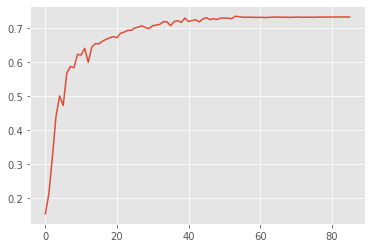

In [48]:
plt.plot(dev_losses)